# Connectivity Inference V2

Date: 08.04.22 -

This notebook contains the second, now structured, version of the conncetivity inference pipeline brian2 --> sPYcon.

In [1]:
############################
######## SETUP  ###########

#####  General Imports ######
import numpy as np
from brian2 import *
from matplotlib import pyplot
import sys
import networkx

##### setup interactive ####
%matplotlib notebook 

In [2]:
############################
##### MODEL SPECIFICS ######

#### Predef.parameters ####
# needed to specifiy simulations
#===========================Set Parameters======================================
# Parameters
C = 281 * pF              # membrane capacitance
gL = 30 * nS              # leak conductance
#taum = C / gL            # ? NOT USED ? ~  time to total leakage of current
EL = -70.6 * mV           # leak reversal potential / resting potential
VT = -50.4 * mV           # threshold potential
DeltaT = 2 * mV           # slope factor (sharpness of spike)
Vcut = VT + 5 * DeltaT    # computational voltage cutoff (not biologically important)

#### Simulation Scripts #####
sys.path.append('../simulations/')
from simAdExV2 import * 

###### Utility Scripts #####
sys.path.append('../tools')
import adEx_util as  adEx_util

In [3]:
###########################
####### RUN SIMULATION ####

### choose parameters ###
# Network
n = 10         # no of neurons
p = 0.1       # prob. of conncetion
c = "i!=j"    # condition of allowed conncections
t = 30000     # total simualtion time  [ms]
ws = 30*mV    # voltage suplied by synaptic conncetion
# Neuron
tauw = 144*ms # adaption time constant [*ms - in brian2 units]
a = 4*nS      # subthreshold adaption constant [*nS - in brian2 units]
b = 0.0805*nA # spike-triggert adaption constant [*nA - in brian2 units]
Vr = -70.6*mV # reset voltage [*mV- in brian2 units]


# run simulation
trace, spikes, S = simpleNetV2(n, p, c, t, ws, tauw, a, b, Vr) # Regular spiking 

WARNING    'ws' is an internal variable of group 'synapses', but also exists in the run namespace with the value 30. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


<IPython.core.display.Javascript object>


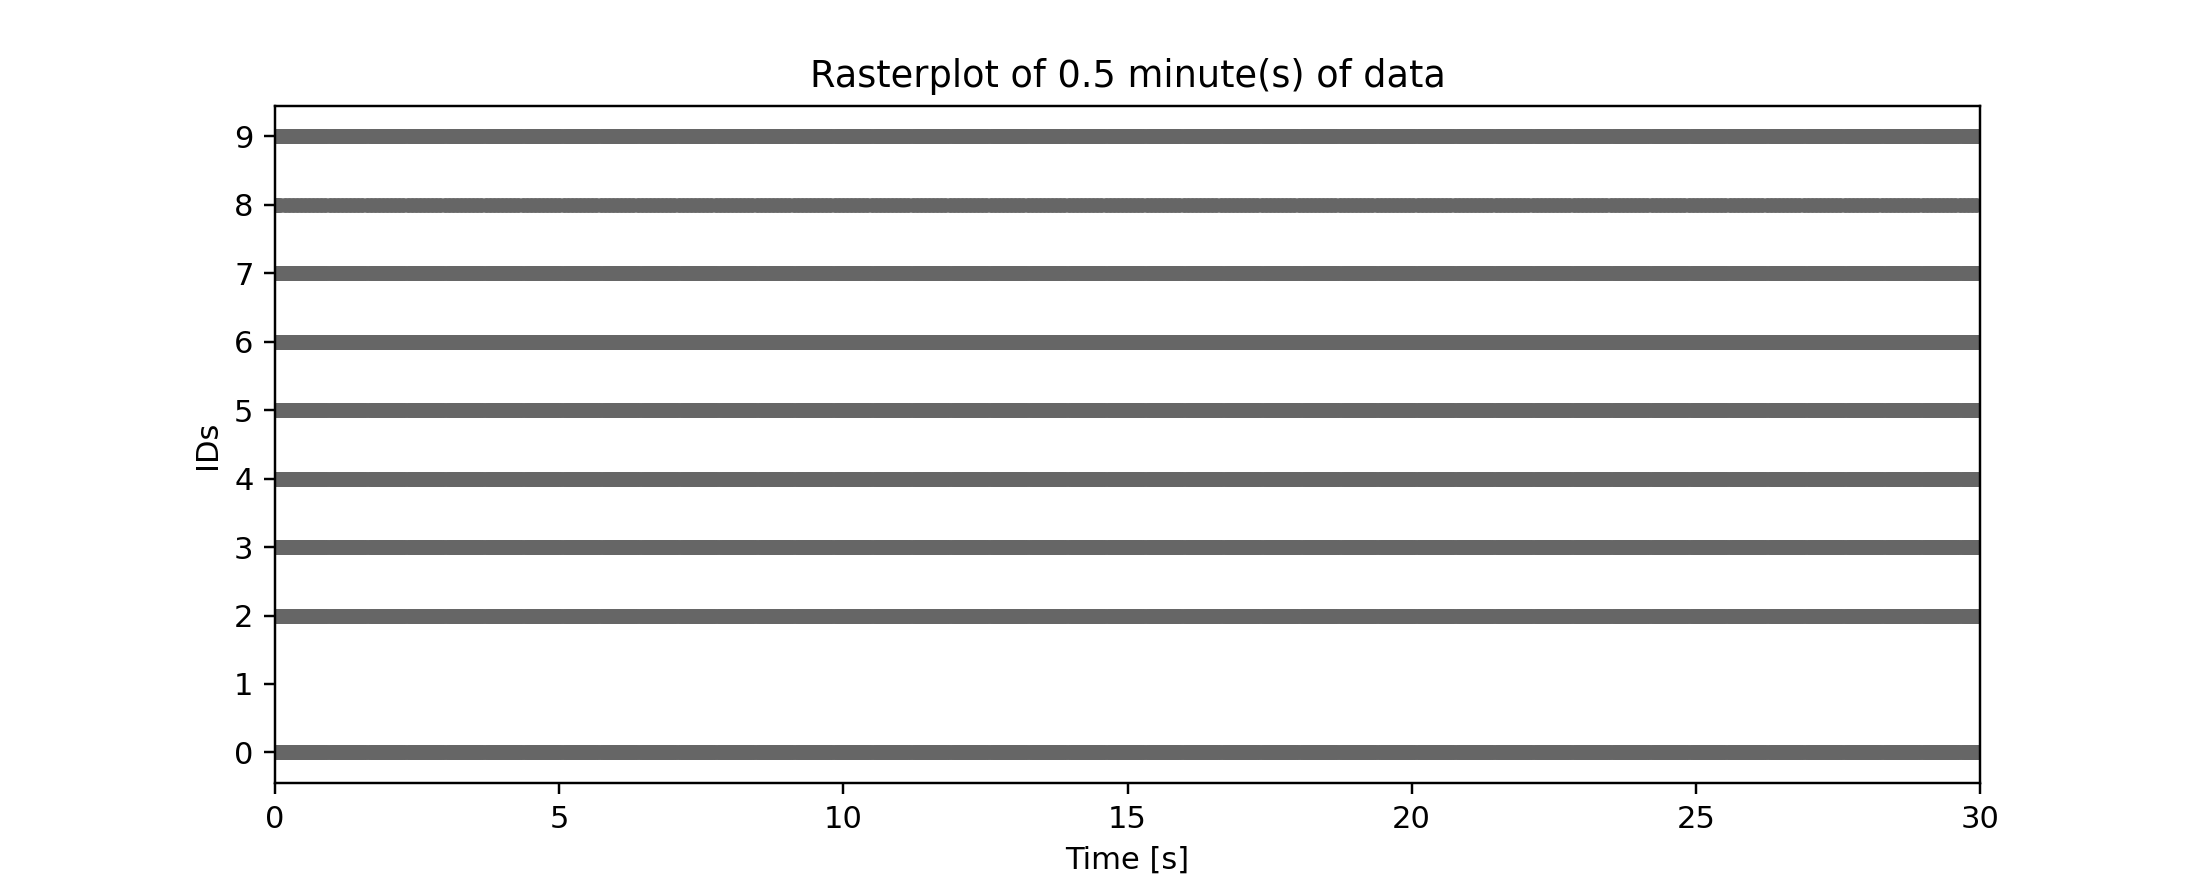

<IPython.core.display.Javascript object>


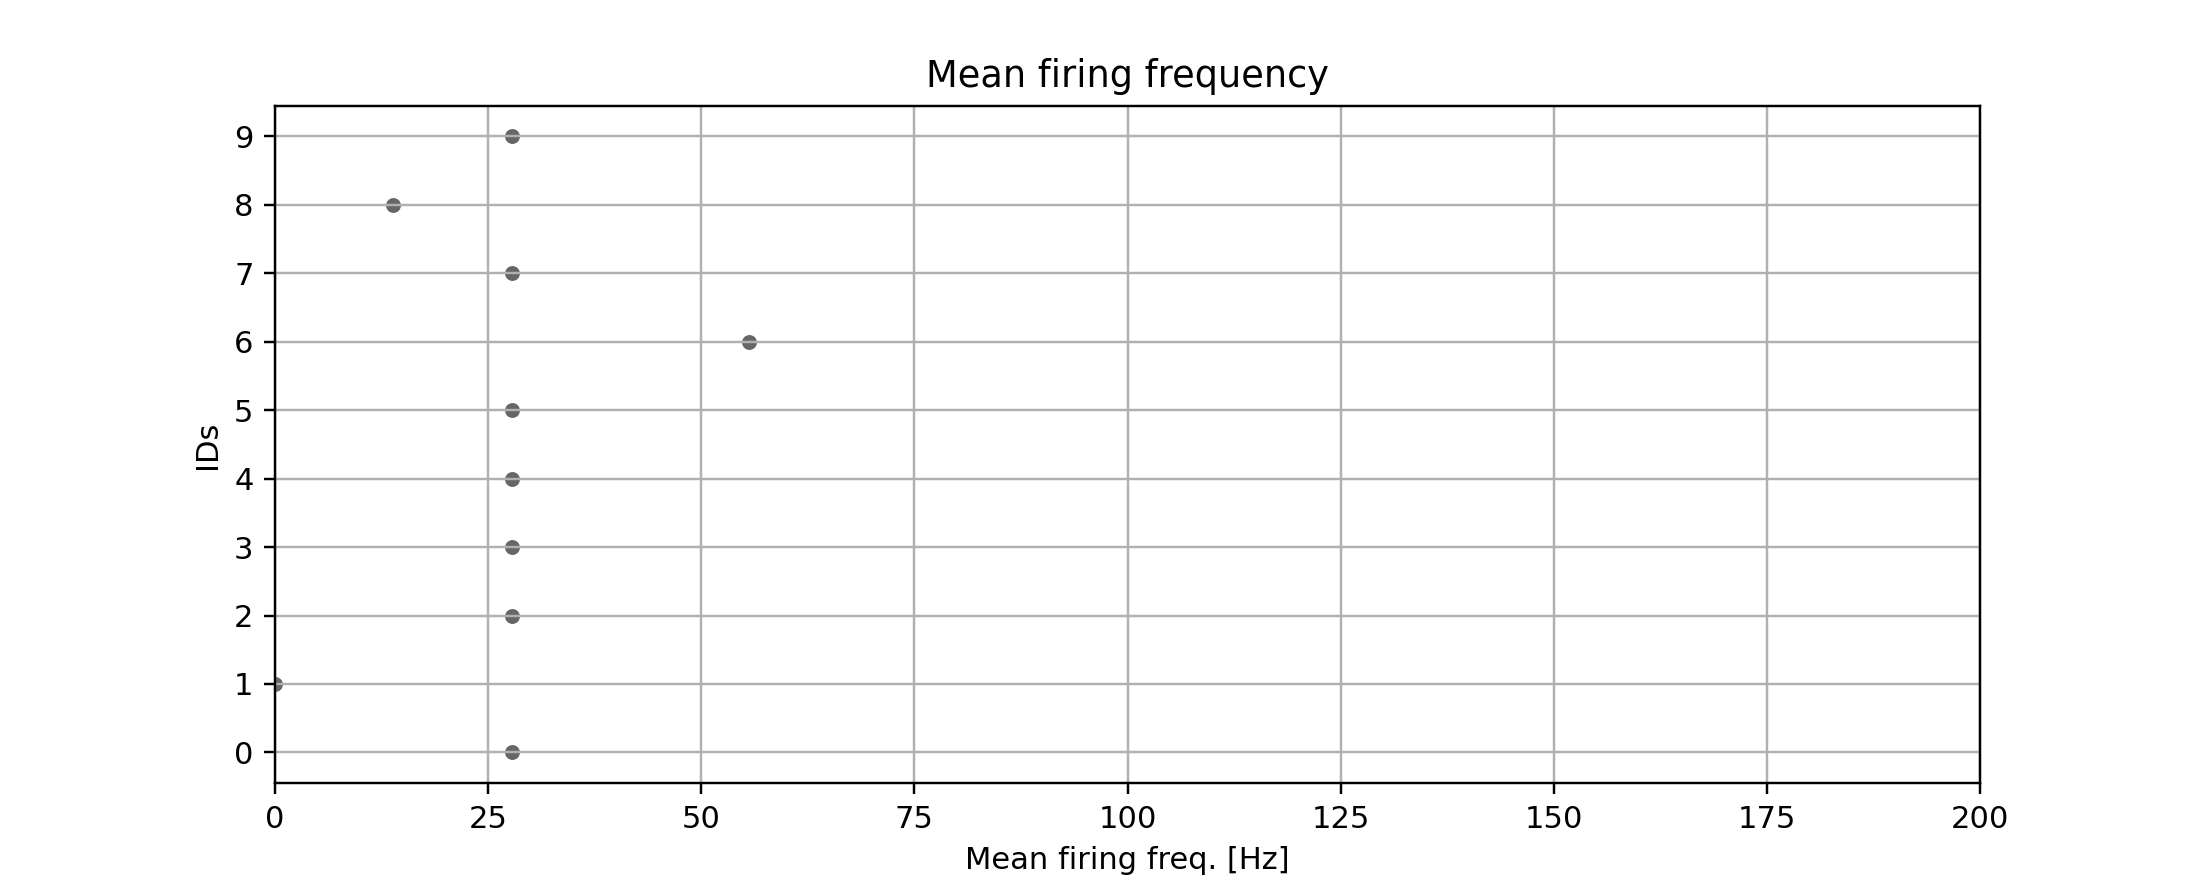

In [4]:
###########################
####### SHOW DATA #########

# unpack spikes
times=spikes.t # [s]
ids=spikes.i  
nodes=numpy.arange(0, n, 1)

# rasterplot
fig = pyplot.figure(figsize=(10,4))
pyplot.scatter(times, ids, s=15, c=[[.4,.4,.4]])
pyplot.yticks(nodes[::1]) # tick every 1 neuron(s)
pyplot.xlim([0,t/1000])
pyplot.ylabel('IDs')
pyplot.xlabel('Time [s]')
pyplot.title('Rasterplot of {:.1f} minute(s) of data'.format(t/(1000*60)))
pyplot.show()

# mean fireing freq.
fig = pyplot.figure(figsize=(10,4))
pyplot.scatter(np.bincount(ids,minlength=n)/(t/1000), nodes, s=15, c=[[.4,.4,.4]])
pyplot.yticks(nodes) # tick every 1 neuron(s)
pyplot.xlim([0,200])
pyplot.ylabel('IDs')
pyplot.xlabel('Mean firing freq. [Hz]')
pyplot.title('Mean firing frequency')
pyplot.grid()
pyplot.show()

In [5]:
#############################
###### Infer. Fn. Conn ######

#Note: Conncectvity can only be inferred for the neurons that have at least one spike.
#      Neurons of no single spike are not shown in the graph.

# conversions fom Brain2 --> sPYcon
times_in_sec = (times/ms) /1000 # convert to unitless times from [ms] -> [s]

# import inference method
sys.path.append('../tools/spycon/src')
from sci_sccg import Smoothed_CCG

# define inference method
coninf = Smoothed_CCG() # English2017

# get ground truth graph of network
marked_edges, nodes = adEx_util.make_marked_edges(ids,S)

### get conncectivity test 
from spycon_tests import load_test, ConnectivityTest
# define test
spycon_test = ConnectivityTest("spycon_test",times_in_sec, ids, nodes, marked_edges)
# run test
spycon_result, test_metrics = spycon_test.run_test(coninf, only_metrics=False, parallel=True,)

7926


<IPython.core.display.Javascript object>


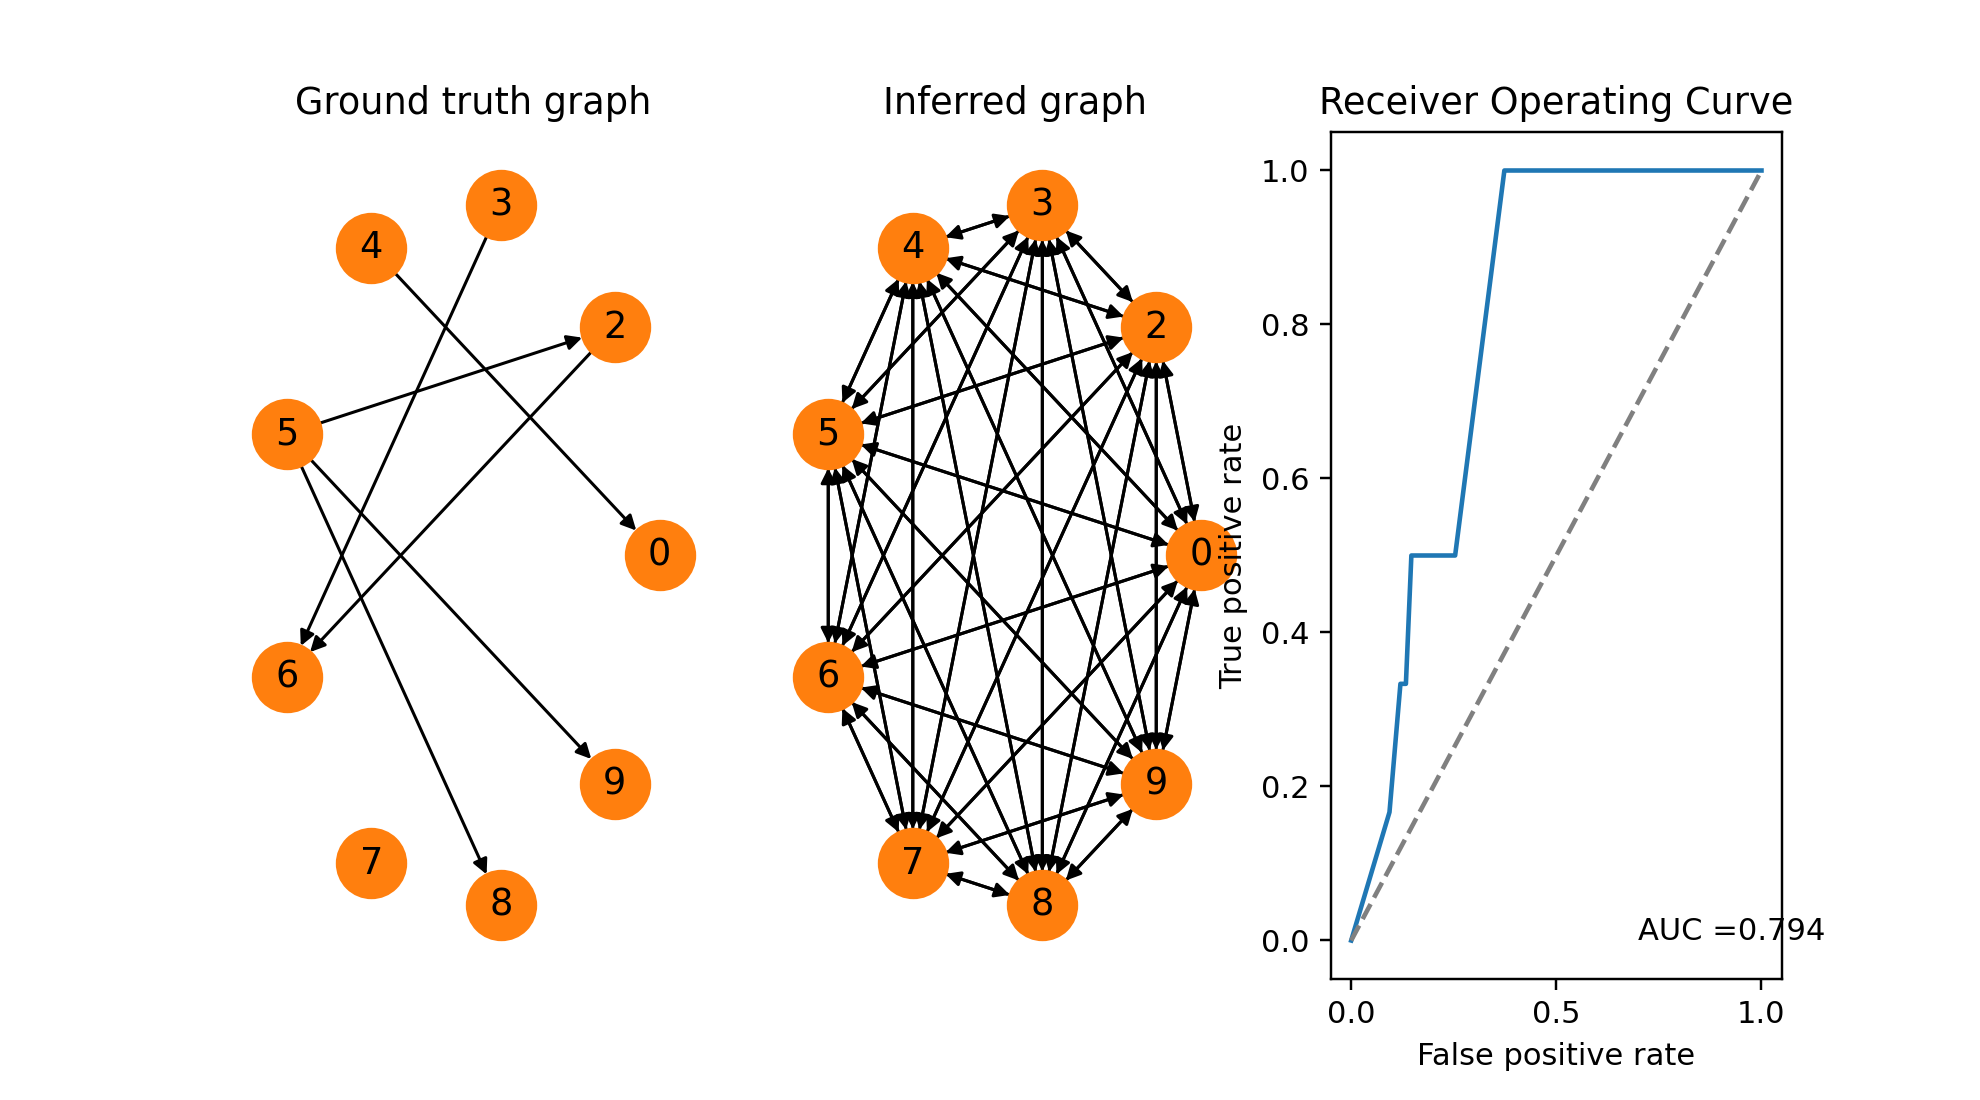

In [6]:
fig = pyplot.figure(figsize=(9,5))
ax1 = fig.add_subplot(131)
spycon_test.draw_graph()
pyplot.title('Ground truth graph')
ax2 = fig.add_subplot(132)
spycon_result.draw_graph(graph_type='binary', ax=ax2)
pyplot.title('Inferred graph')
ax3 = fig.add_subplot(133)
fpr, tpr, auc = tuple(test_metrics[['fpr', 'tpr', 'auc']].to_numpy()[0])
pyplot.plot(fpr, tpr)
pyplot.plot([0,1],[0,1], color='gray', linestyle='--')
pyplot.text(.7,.0,'AUC =%.3f' %auc)
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('Receiver Operating Curve')
pyplot.show()

<IPython.core.display.Javascript object>


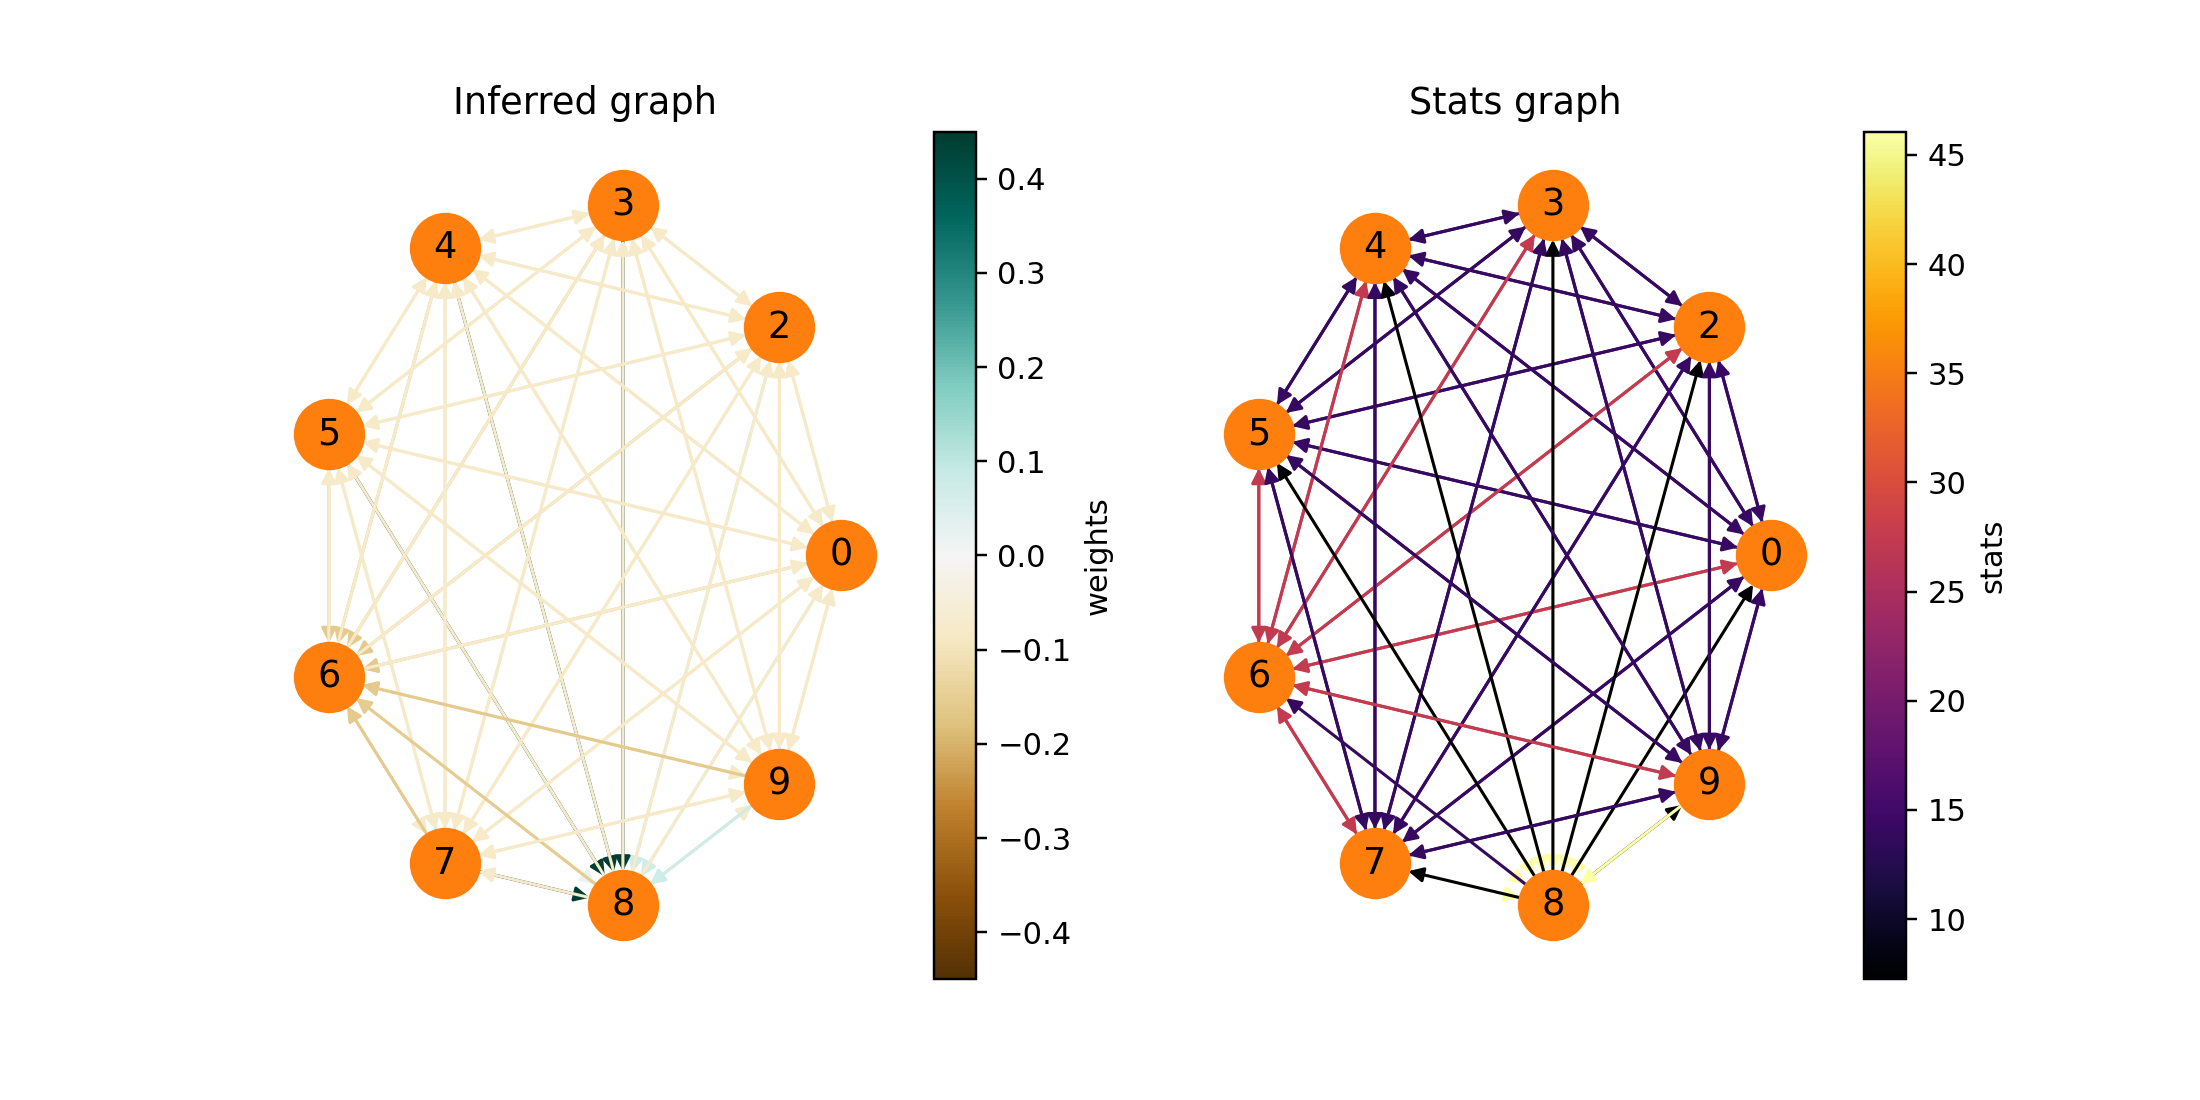

In [7]:
fig = pyplot.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
spycon_result.draw_graph(graph_type='weighted', ax=ax1)
ax1.set_title('Inferred graph')
ax2 = fig.add_subplot(122)
spycon_result.draw_graph(graph_type='stats', ax=ax2)
ax2.set_title('Stats graph')
pyplot.show()